## Optimization for Machine Learning and Neural Networks
### Prof. Giovanni Neglia - Tareq Salem
### Student Name: Franz Franco

#### Momentum method and Nesterov's Accelerated Gradient
Momentum method is a technique for accelerating the stochastic gradient descent(SGD) method, the momentum update can be motivated from a physical perspective by introducing a velocity component. A velocity vector is accumulated in directions that consistenly reduce the cost function, allowing update the parameters in a direction that is more effective than steepest descent. Nesterov's accelerated gradient(NAG) is a variant of momentum method, the main difference is that we also apply a momentum update to the parameters and the gradient is computed with these updated parameters in each step. Momentum methods approach most of the time achieve better convergence rates on deep neural networks compared with vanilla SGD.

Optimizers:
* Gradient Descent
* Mini batch gradient descent
* Momentum
* Nesterov's Accelerated Gradient

#### Toy example: 

In [21]:
# importing libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Synthetically creating points around the line 
$$
y = ax + b
$$
by adding noise to the output. So, effectively,  
$$
y = ax + b + \varepsilon, \quad where 
$$
$$
\varepsilon \in N(0, \sigma^2)
$$

In [101]:
x_min = -20
x_max = 20
N_samples = 800
noise_level = 3
a = -3
b = 10
#defining function ground truth f(x)
def f(x):
    return(a*x + b) 

# definine function for sampling from f(x) and add some noise
def sample_data_batch_noise(x_min,x_max, N_samples, noise_level):    
    ## The x-data is fixed (no variability here)
    X = np.linspace(x_min,x_max,N_samples)
    noise = noise_level * np.random.randn(N_samples)
    ## The variability here depends only from the noise we add on the samples
    return [X,f(X) + noise]

x, y = sample_data_batch_noise(x_min, x_max, N_samples, noise_level)

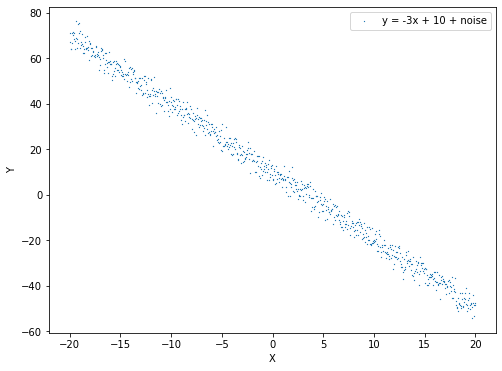

In [102]:
plt.figure(figsize = [8,6])
plt.scatter(x, y, marker='x', s=0.1)
plt.xlabel('X'); plt.ylabel('Y')
plt.legend( ['y = ' + str(a) + 'x + ' + str(b) +' + noise'])

The data is shown above is a line with gaussian noise added. Where the ground truth is known: $y=-3x+10$

We start with some initial pair (a,b) and moving as per the directions of the optimizer till we find the value of (a,b) minimizes the mean squared error over all data points (global minima) or a batch of data points (local minima). 

We define the Mean Square Error function: 
$$
Rs = \frac{1}{n}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$

In [103]:
# Compute loss
def compute_loss(a, b):
    return np.mean(np.square(y - (a*x + b)),2)

In [107]:
# Visualizing the loss function for all values of a and b.
a_range, a_step = 20, 0.1
b_range, b_step = 200, 1

# Getting full ranges
a_range = np.arange(a - a_range, a + a_range, a_step)
b_range = np.arange(b - b_range, b + b_range, b_step)

# Make them into a grid
bgrid, agrid = np.meshgrid(b_range, a_range)

# Computing the loss function
size_x = np.int(a_range / a_step * 2)
size_y = np.int(b_range / b_step * 2)
agrid_tiled = np.tile(np.reshape(agrid, [size_x, size_y, 1]), [1,1,x.shape[0]])
bgrid_tiled = np.tile(np.reshape(bgrid, [size_x, size_y,1]), [1,1,x.shape[0]])
loss_full_grid = compute_loss(agrid_tiled, bgrid_tiled)

Text(0.5, 1.0, 'Mean loss values across for different b values')

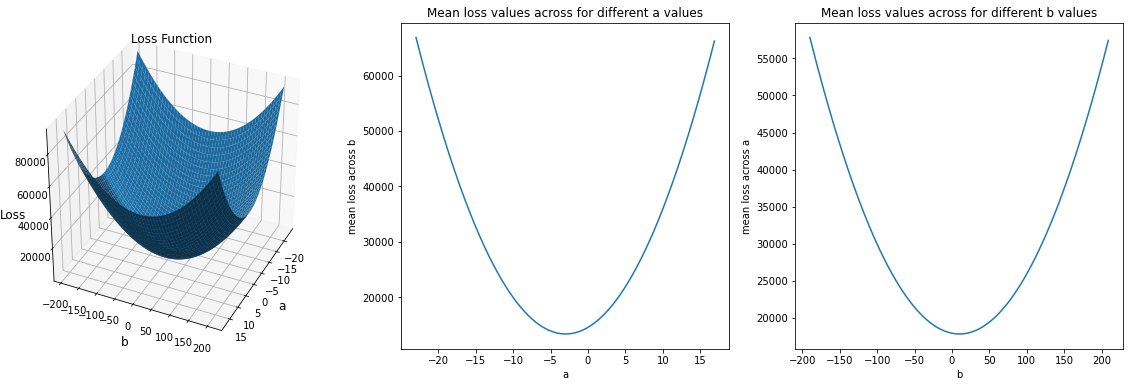

In [116]:
# Spherical coordinate system 
azimuth_angle = 25
elevation_angle = 35

fig = plt.figure(figsize = [20,6])
ax = fig.add_subplot(131, projection = '3d')
ax.view_init(elev = elevation_angle, azim = azimuth_angle)
ax.plot_surface(agrid, bgrid, loss_full_grid)
ax.set_xlabel('a', fontsize=12);  ax.set_ylabel('b', fontsize=12)
ax.set_zlabel('Loss', fontsize=12)
ax.set_title('Loss Function', fontsize=12)

ax = fig.add_subplot(132)
plt.plot(a_est_range, np.mean(loss_full_grid, axis=1))
plt.xlabel('a')
plt.ylabel('mean loss across b')
plt.title('Mean loss values across for different a values')
ax = fig.add_subplot(133)
plt.plot(b_est_range, np.mean(loss_full_grid, axis=0))
plt.xlabel('b')
plt.ylabel('mean loss across a')
plt.title('Mean loss values across for different b values')

### Ridge Regression solution

The solution to this mean squared minimization with Ridge regression approach, This can be expressed as :
$$
   Y= \omega^{T} X + \lambda   \| \omega \| ^{2} 
$$

$$
\omega = (X^T X)^{-1}X^T Y
$$

where $X$ is the features set with a column of 1's appended for the intercept value computation 

In [145]:
from numpy import identity as I
from numpy import matmul as M
from numpy.linalg import inv

# function compute_w1
def compute_w1(X, y, _lambda):
    n = X.shape[0]
    d = 1
    X_t = np.ones((n,d+1))
    X_t[:,1:] = X.reshape(n,d)
    w1 = M(M(inv(M(X_t.T, X_t) + n*_lambda*I(d+1)), X_t.T), y)
    return w1

# function predict_1
def predict_1(X, w1):
    n = X.shape[0]
    d = 1
    X_t = np.ones((n,d+1))
    X_t[:,1:] = X.reshape(n,d)
    y_pred = M(X_t, w1)
    return y_pred

In [175]:
_lambda = 0.01
w1 = compute_w1(x, y, _lambda)
print("#####Ground truth#####")
print('a: ', a, 'b: ', b)
print("#####Ridge Solution#####")
print('a_pred: ',round(w1[1],3), 'b_pred: ', round(w1[0],3))

#####Ground truth#####
a:  -3 b:  10
#####Ridge Solution#####
a_pred:  -2.989 b_pred:  9.89


### Gradients computation
Computing the gradients w.r.t a and b, we have
$$
J = \frac{1}{n}\sum_{i=1}^n(y_i - (a x_i + b) )^2 ,           \nabla J = ( \frac{\partial J}{\partial a} , \frac{\partial J}{\partial b})
$$

In [178]:
#Computing grad for a and b
def gradient(x, y, theta):
    a,b = theta[0], theta[1]
    err = a * x + b - y
    loss = sum(err * err)
    grad_a = sum(x * err)
    grad_b = sum(err)
    return np.array([grad_a, grad_b]), loss

# It does what the name says it does..
def get_random_batch(x, y, batch_size):
    i = np.random.randint(0, x.shape[0]-1, size = batch_size)
    return(x[i], y[i])

# Move these below 2 functions out of the notebook!!
def plot_all_results(grad, abvalue, loss, velocity = None):
    plt.figure(figsize = [20, 6])
    plt.subplot(141)
    plt.plot(abvalue[:,0])
    plt.title('"a" values'); plt.xlabel("# Steps")
    plt.ylabel('a')
    plt.subplot(142)
    plt.plot(abvalue[:,1])
    plt.title('"b" values'); plt.xlabel("# Steps")
    plt.ylabel('b')
    plt.subplot(143)
    plt.plot(loss)
    plt.title("Loss"); plt.xlabel("# Steps")
    plt.ylabel('loss')
    if velocity is not None:
        plt.subplot(144)
        plt.plot(velocity[:, 0])
        plt.plot(velocity[:, 1], 'r*')
        plt.legend(['Velocity of grad_a', 'Velocity of grad_b'])

# Empty spaces for filling in stuff. Storing since we'll need them for plotting
def init_data(num_epochs):
    grad = np.zeros([num_epochs, 2], dtype=float)
    abvalue = np.zeros([num_epochs, 2], dtype=float)
    loss = np.zeros([num_epochs, 1], dtype=float)
    velocity = np.zeros([num_epochs, 2], dtype=float)
    
    return grad, abvalue, loss, velocity

# Let's shuffle the array
ix = np.arange(0,x.shape[0])
np.random.shuffle(ix)
x = x[ix]
y = y[ix]

#getting the batch of data for passed indices
def get_data_from_batch(x,y,idx,batch_size):
    start_ix = idx*batch_size
    end_ix   = min(start_ix + batch_size, x.shape[0])
    return (x[start_ix:end_ix], y[start_ix:end_ix])

### Batch Gradient Descent

* Simplest of all optimizers
* Just one parameter - learning rate (denoted by $\eta$)
* Move in the direction opposite of the gradient
* Guaranteed to converge to global optimum (convex function) and local optimum otherwise


**Update rule**
$$
\theta_t = \theta_{t-1} - \eta \cdot \nabla J(\theta_{t-1})
$$

**Cons**
* Memory intensive - loads the full dataset and computes gradients


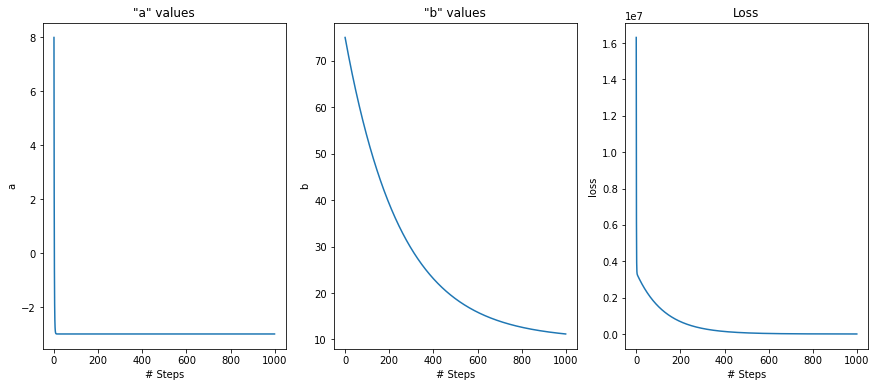

In [179]:
# Batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 1000
eta = 5e-6

grad_store, abvalue_store, loss_store, _ = init_data_store(num_epochs)

theta = np.array([initial_a, initial_b])

for i in range(num_epochs):
    abvalue_store[i,:] = theta
    
    #calculate gradient
    grad, loss = gradient(x,y, theta)
    
    #update rule
    delta_theta = eta * grad
    theta = theta - delta_theta
    
    # storing them to display later
    grad_store[i] = grad
    loss_store[i] = loss
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Mini batch gradient descent

This is the same as above gradient descent, except that the update is performed on a mini batch of user specified size. 

* Less memory intensive
* Noisy convergence
* More commonly used in neural nets/ problems that don't fit in memory

**Update rule** 
$$
\theta_t = \theta_{t-1} - \eta \cdot \nabla J_{batch}(\theta_{t-1})
$$

where $J_{batch}$ is the loss over the mini batch under process

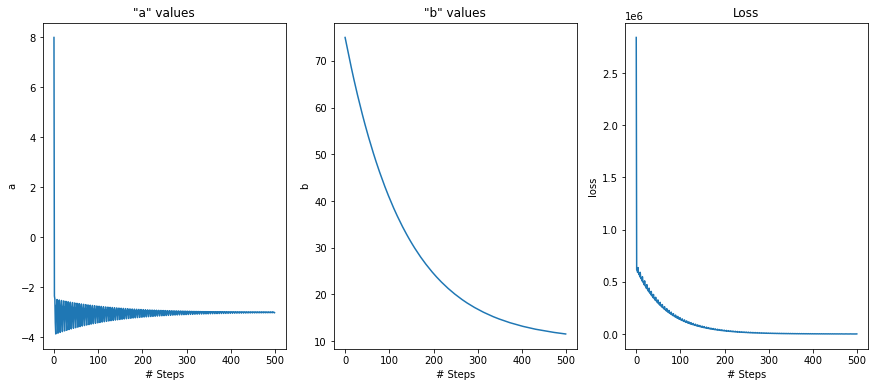

In [180]:
# Mini batch gradient descent

initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        #calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update parameters
        theta = theta - eta * grad
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

Observe the noisy convergence in the above case when we used mini batches of data. Vary the batch size parameter above and observe the variations in the result. 

### Momentum

* To lead to faster convergence when gradient changes slowly along one of the dimensions as is the case above

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1})
$$

$$
\theta_t = \theta_{t-1} - v_t
$$

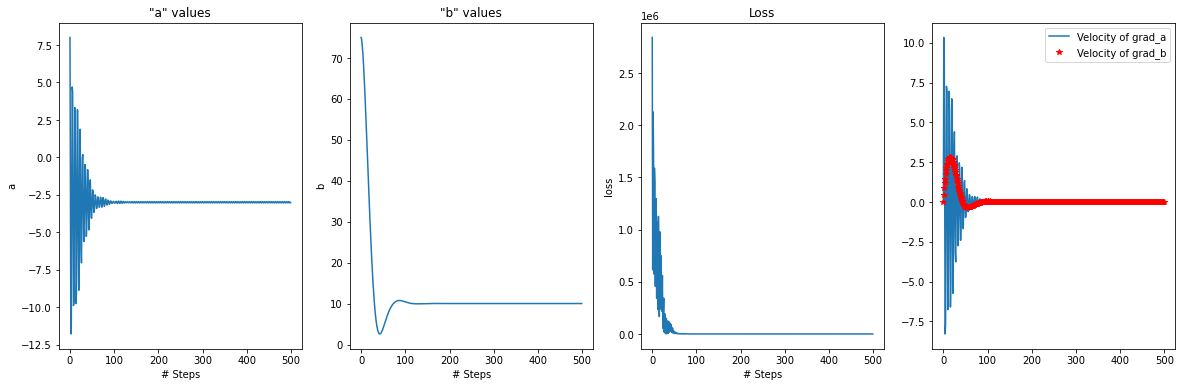

In [181]:
initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update rule
        velocity = gamma* velocity + eta * grad
        theta = theta - velocity
        
        # store
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Nesterov

* To prevent the ball from sliding up the other slope with all the momentum it gained while coming down

$$
v_t = \gamma v_{t-1} + \eta \nabla J(\theta_{t-1} - \gamma v_{t-1})
$$

$$
\theta_t = \theta_{t-1} - v_t
$$

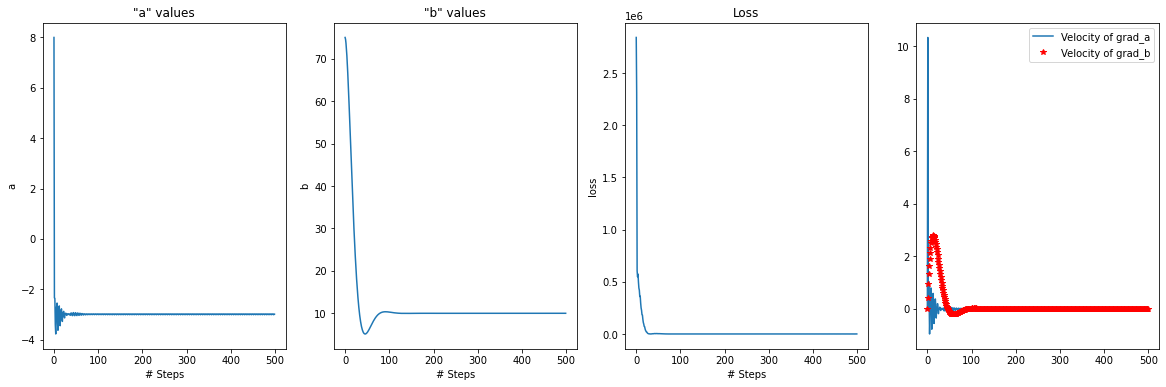

In [182]:
initial_a = 8
initial_b = 75
num_epochs = 100
eta = 5e-5
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
gamma = 0.9

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # computing gradient at lookahead theta
        look_ahead_theta = theta - gamma*velocity
        grad, loss = gradient(x_batch, y_batch, look_ahead_theta)
        
        # update the params
        velocity = gamma* velocity + eta * grad
        theta = theta - velocity
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store, velocity_store)

### Adagrad

Adagrad is an algorithm for gradient-based optimization that does just this: It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data.

$$
\theta_{t,i} = \theta_{t-1,i} - \frac{\eta }{\sqrt{G_{t,ii} + \epsilon}} \cdot \nabla J(\theta_{t-1,i})
$$

where $G_{t,ii} \in R^{d×d}$ is a diagonal matrix where each diagonal element i, i is the sum of the squares of the
gradients w.r.t. the parameter up to time step $t$, while $\epsilon$ is a smoothing term that avoids division by zero (usually
on the order of 1e-8)

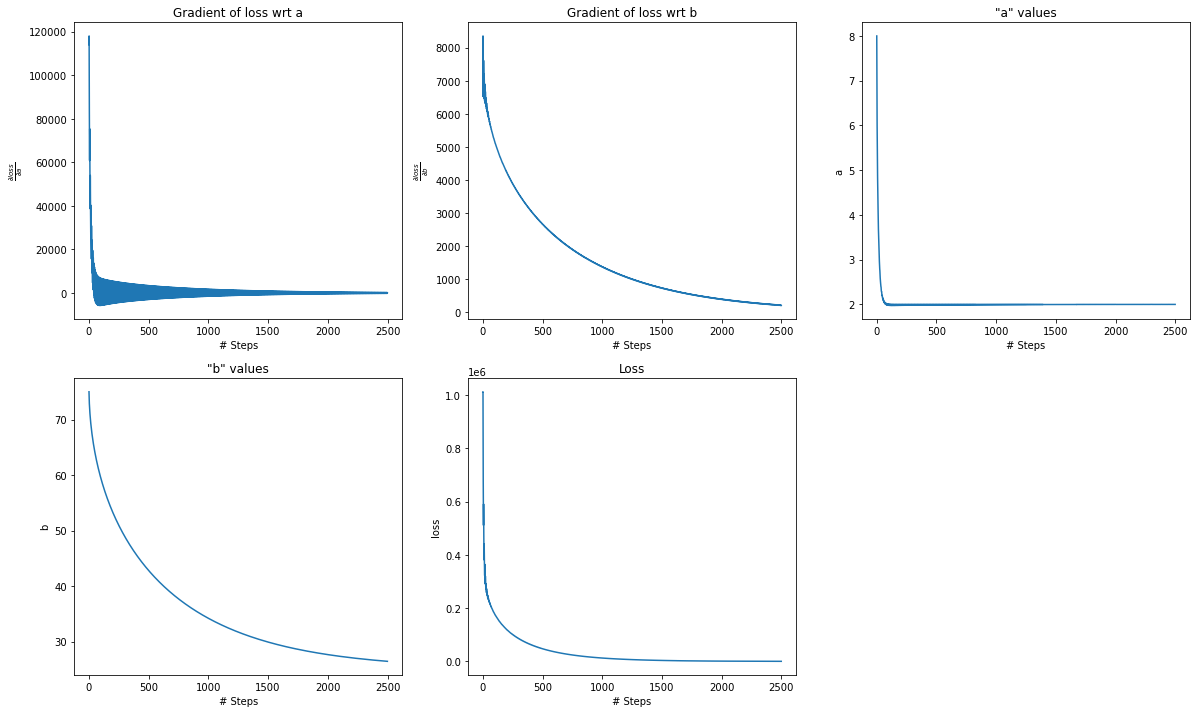

In [14]:
initial_a = 8
initial_b = 75
num_epochs = 500
eta = 0.9
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
eps = 1e-8

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        
        # get the batch
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # Compute the gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        grad_store[i] = grad
        
        # Compute G and update params
        G = np.sum(np.square(grad_store), axis=0)
        theta = theta - eta * grad / np.sqrt(G + eps)
        
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Adadelta / (RMSProp)

Adadelta is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g^2_t $$ where $g_t = \nabla J(\theta)$

$$
\theta_{t,i} = \theta_{t-1,i} - \frac{\eta }{\sqrt{E[g^2]_{t,i} + \epsilon}} \cdot \nabla J(\theta_{t-1,i})
$$

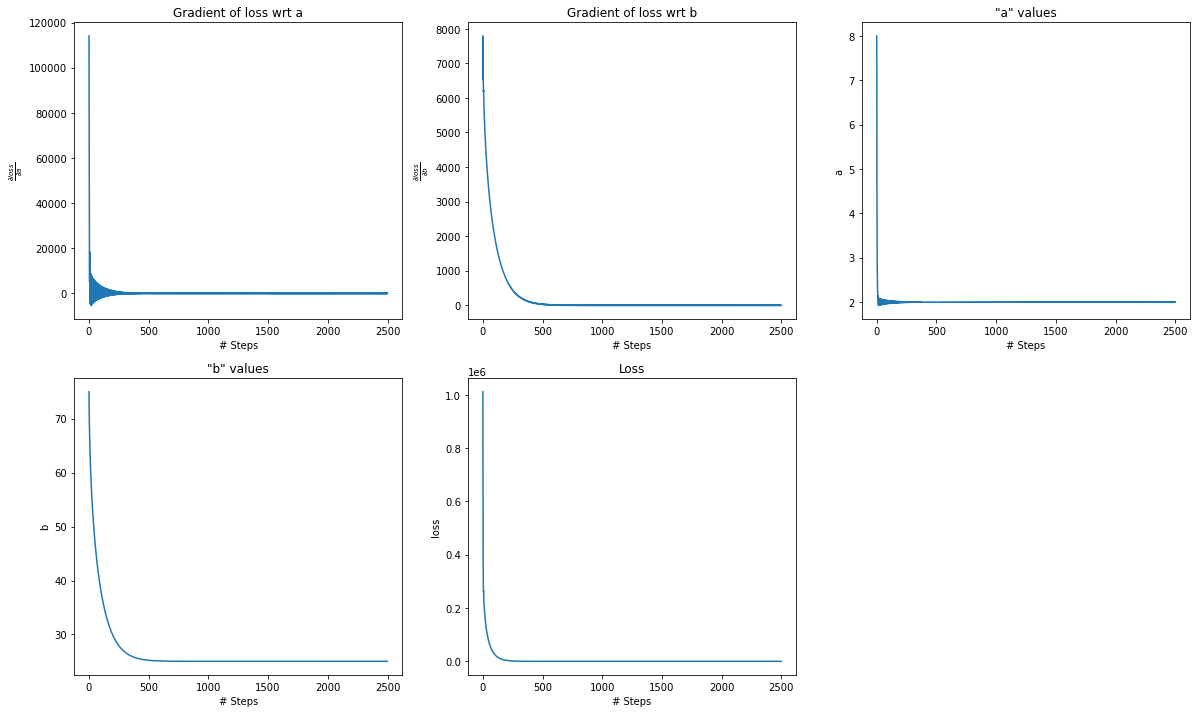

In [15]:
initial_a = 8
initial_b = 75
num_epochs = 500
eta = 8e-2
batch_size = 150 # Lower this and watch the plots grow messy
n_batches = int(x.shape[0]/batch_size)
eps = 1e-8
gamma = 0.999

grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])
i=0
expected_grad = np.array([0,0])
for epoch in range(num_epochs):   
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get the data and compute gradient 
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # compute update rule
        expected_grad = gamma * expected_grad + (1 - gamma) * np.square(grad)
        RMS_grad = np.sqrt(expected_grad + eps)
        delta_theta = -(eta/RMS_grad) * grad
        
        theta = theta + delta_theta
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results(grad_store, abvalue_store, loss_store)

### Adam

Adaptive Moment Estimation (Adam) is another method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients $v_t$ like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients $m_t$, similar to momentum

here $g_t = \nabla J(\theta)$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$

$$
v_t = \beta_2v_{t-1} + (1 - \beta_2)g^2_t 
$$

$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$

$$ \theta_{t} = \theta_{t-1} - \frac{\eta }{\sqrt{\hat{v}_{t-1} + \epsilon}} \cdot \hat{m}_{t-1} $$

Wall time: 82.5 ms


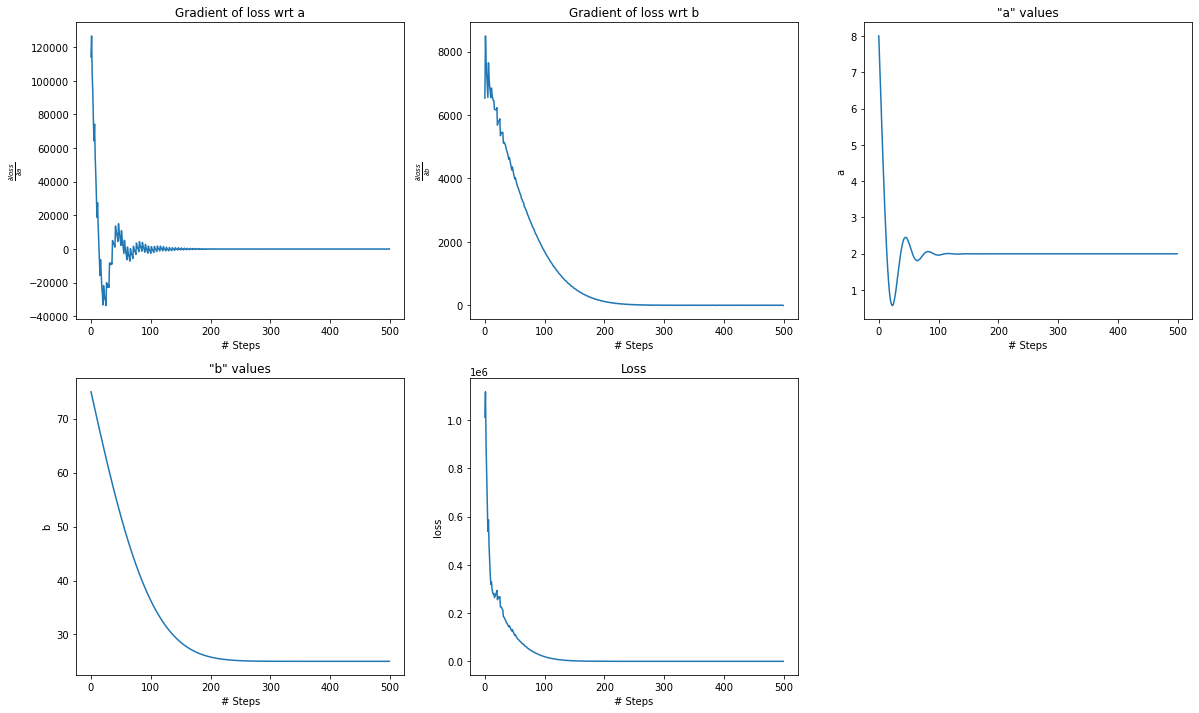

In [16]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 100
epsilon = 1e-8
theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 150
eta = 5e-1
n_batches = int(x.shape[0]/batch_size)
grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


mt = np.array([0, 0])
vt = np.array([0, 0])

i=0
for epoch in range(num_epochs):
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get data and compute gradient
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)

        # approximate first and second moment
        mt = beta1 * mt + (1 - beta1) * grad
        vt = beta2 * vt + (1 - beta2) * np.square(grad)
    
        # bias corrected moment estimates
        mhat = mt / (1 - beta1 ** (i+1) )
        vhat = vt / (1 - beta2 ** (i+1) )
        
        # update the params
        delta_theta = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
        theta = theta + delta_theta
        
        grad_store[i,:] = grad
        loss_store[i] = loss
        i += 1
        
plot_all_results(grad_store, abvalue_store, loss_store)

## AdaMax
Norms for large p values generally become numerically unstable, which is why $l_1$ and $l_2$ norms are
most common in practice. However, $l_\infty$ also generally exhibits stable behavior. For this reason, the
authors propose AdaMax and show that vt with $l_\infty$ converges to the following more stable value

here $g_t = \nabla J(\theta)$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$

$$
u_t = \beta^\infty_2 u_{t-1} + (1 - \beta_2^\infty)|g_t|^\infty
$$

$$
u_t = max(\beta_2 \cdot u_{t-1}, |g_t|) 
$$

$$
\theta_{t} = \theta_{t-1} - \eta \frac{m_t}{u_t}
$$

Wall time: 80.8 ms


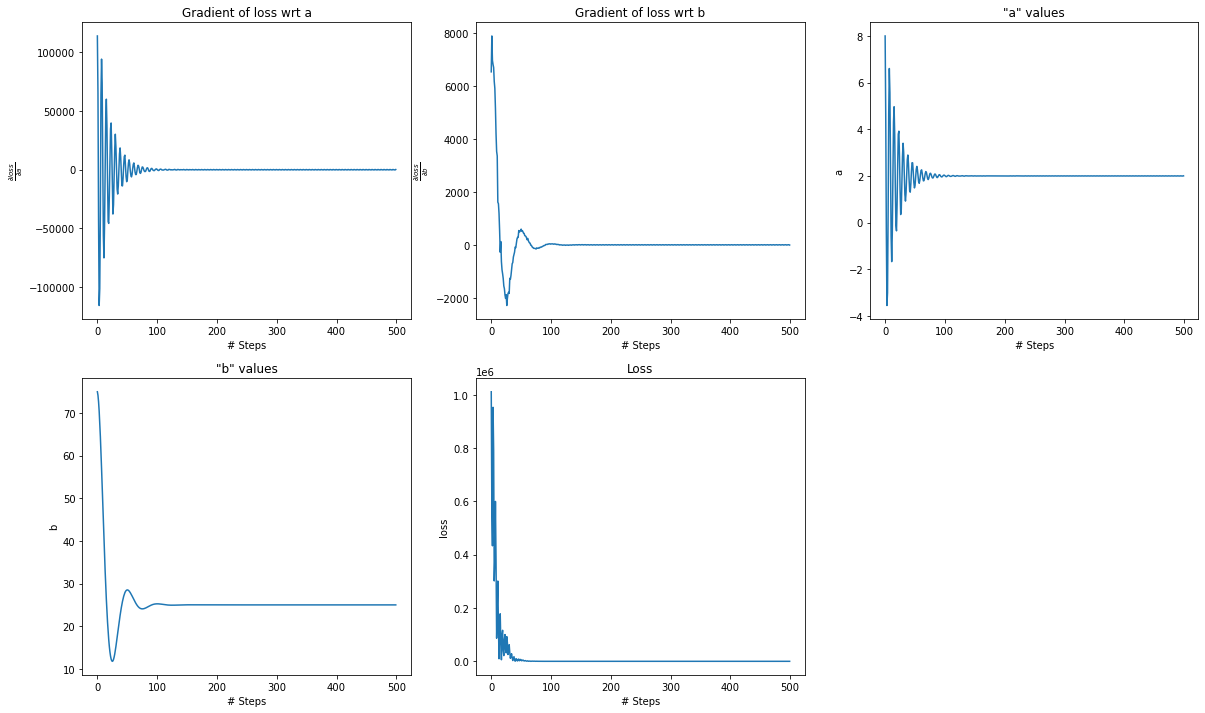

In [17]:
%%time
initial_a = 8
initial_b = 75
num_epochs = 100
theta = np.array([initial_a, initial_b])
beta1 = 0.9
beta2 = 0.999
batch_size = 150
eta = 1e-1
n_batches = int(x.shape[0]/batch_size)
grad_store, abvalue_store, loss_store, velocity_store = init_data_store(num_epochs*n_batches)


mt = np.array([0, 0])
ut = np.array([0, 0])

i=0
for epoch in range(num_epochs):
    
    for batch_idx in range(n_batches):
        
        abvalue_store[i] = theta
        
        # get data and compute gradient
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        grad, loss = gradient(x_batch, y_batch, theta)

        # approximate first and second moment
        mt = beta1 * mt + (1 - beta1) * grad
        ut = np.max([beta2 * ut, np.abs(grad)], axis=0)
        
        # update the params
        delta_theta = -1 * eta * mt/(np.sqrt(ut))
        theta = theta + delta_theta
        
        grad_store[i,:] = grad
        loss_store[i] = loss
        i += 1
        
plot_all_results(grad_store, abvalue_store, loss_store)